Write something about ETS

Write something about GPS data

In [1]:
# Load Python modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import DWT

%matplotlib inline

In [2]:
# Choice of station
station = 'PGC5'
direction = 'lon'
dataset = 'cleaned'
filename = '../data/PANGA/' + dataset + '/' + station + '.' + direction

In [3]:
# Load the data
data = np.loadtxt(filename, skiprows=26)
time = data[:, 0]
disp = data[:, 1]

In [4]:
# Look for repeated times
dt = np.diff(time)
gap = np.where(dt < 1.0 / 365.0 - 0.001)[0]
print(gap)

[3951]


In [5]:
# Look at the values around this time
print(time[gap[0] - 2 : gap[0] + 4])
print(dt[gap[0] - 2 : gap[0] + 4])

[2011.73717 2011.7399  2011.74264 2011.74264 2011.74538 2011.75086]
[0.00273 0.00274 0.      0.00274 0.00548 0.00273]


In [6]:
# Clean the data around this time
time[gap[0] + 1] = time[gap[0] + 2]
time[gap[0] + 2] = 0.5 * (time[gap[0] + 2] + time[gap[0] + 3])
print(time[gap[0] - 2 : gap[0] + 4])

[2011.73717 2011.7399  2011.74264 2011.74538 2011.74812 2011.75086]


In [7]:
# Look for gaps larger than 2 days in the data
days = 2
dt = np.diff(time)
gap = np.where(dt > days / 365.0 + 0.001)[0]
print(time[gap])
print(gap)

[2001.38809 2002.05339 2002.09446 2002.68857 2006.90212 2014.90212
 2017.20192]
[ 338  577  578  655 2189 5102 5937]


In [8]:
# Select a subset of the data without big gaps
ibegin = 2189
iend = 5102
time_sub = time[ibegin + 1 : iend + 1]
disp_sub = disp[ibegin + 1 : iend + 1]

In [9]:
# Get all gaps in the new data subset
dt = np.diff(time_sub)
gap = np.where(dt > 1.0 / 365.0 + 0.001)[0]
print(gap)

[ 752  753 2143 2460 2637]


In [10]:
# Insert additional values into the data
for i in range(0, len(gap)):
    time_sub = np.insert(time_sub, gap[i] + 1, time_sub[gap[i]] + 1.0 / 365.0)
    disp_sub = np.insert(disp_sub, gap[i] + 1, 0.5 * (disp_sub[gap[i]] + disp_sub[gap[i] + 1]))
    gap = gap + 1

In [11]:
# Get the final length of the data
print(len(time_sub))
print(time_sub[0])
print(time_sub[-1])

2918
2006.91581
2014.90212


In [12]:
# As there is a slow slip event in January 2007, we keep the beginning of the data
# We make sure that the number of data is proportional to 2**9
time = time_sub[0 : 5 * 2**9]
disp = disp_sub[0 : 5 * 2**9]

In [13]:
# Now let us compare the NPES of the DWT cefficients for different wavelet filters
def plot_NPES(X, names, J, xmax, title):
    """ Plot NPES of DEWT coefficients
        X = Time series
        names = List of wavelet filters
        J = Level of DWT
        xmax = Maximum limit of x-axis for plot
        title = Plot title
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    C = DWT.NPES(X)
    plt.plot(np.arange(0, len(C), 1), C, 'k', label='Data')
    colors = cm.rainbow(np.linspace(0, 1, len(names)))
    for name, c in zip(names, colors):
        W = DWT.pyramid(X, name, J)
        C = DWT.NPES(W)
        plt.plot(np.arange(0, len(C), 1), C, color=c, label=name)
    plt.xlim(0, xmax)
    plt.title(title, fontsize=24)
    plt.xlabel('Number of coefficients', fontsize=24)
    plt.ylabel('NPES', fontsize=24)
    plt.legend()

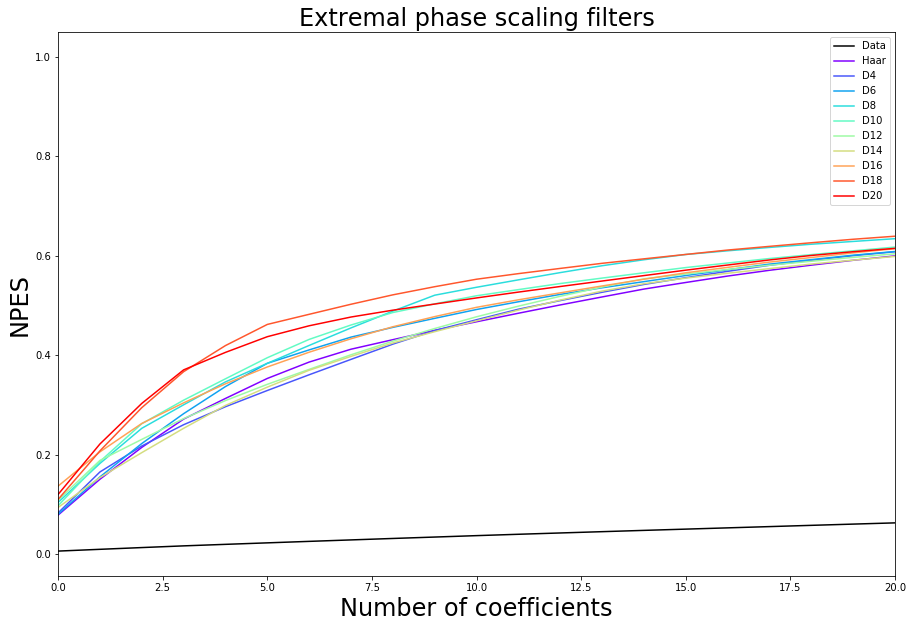

In [14]:
plot_NPES(disp, ['Haar', 'D4', 'D6', 'D8', 'D10', 'D12', 'D14', 'D16', 'D18', 'D20'], 9, 20, \
    'Extremal phase scaling filters')

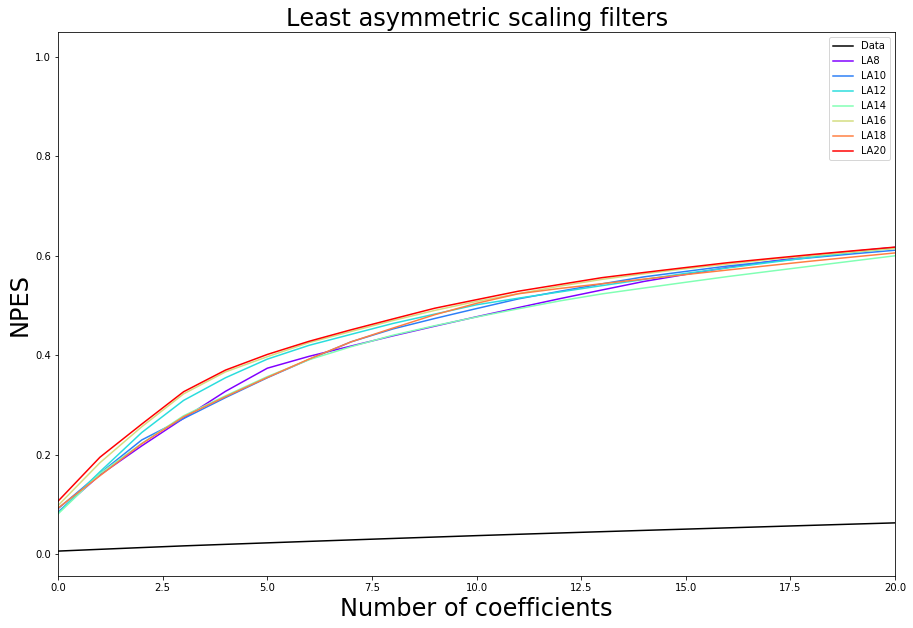

In [15]:
plot_NPES(disp, ['LA8', 'LA10', 'LA12', 'LA14', 'LA16', 'LA18', 'LA20'], 9, 20, \
    'Least asymmetric scaling filters')

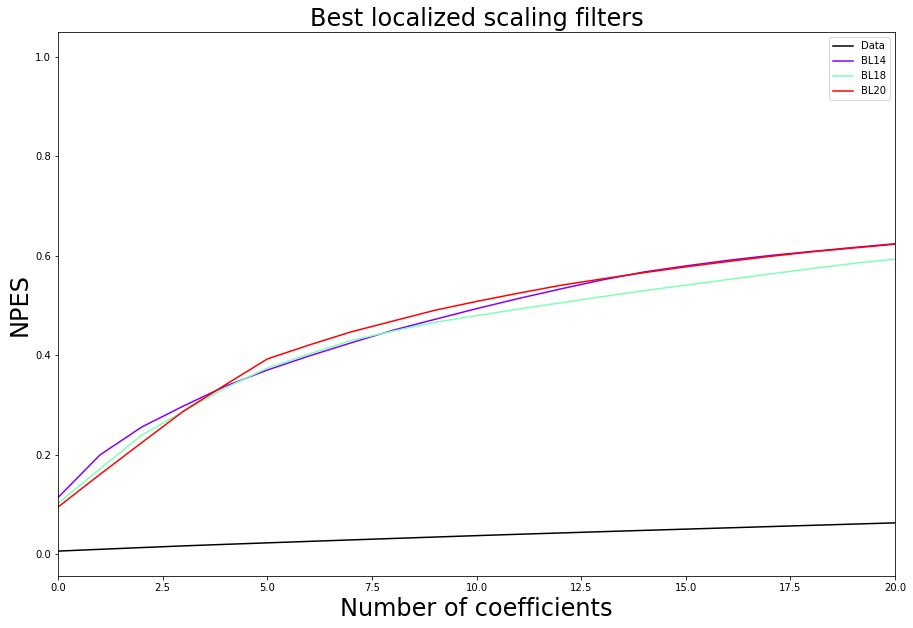

In [16]:
plot_NPES(disp, ['BL14', 'BL18', 'BL20'], 9, 20, \
    'Best localized scaling filters')

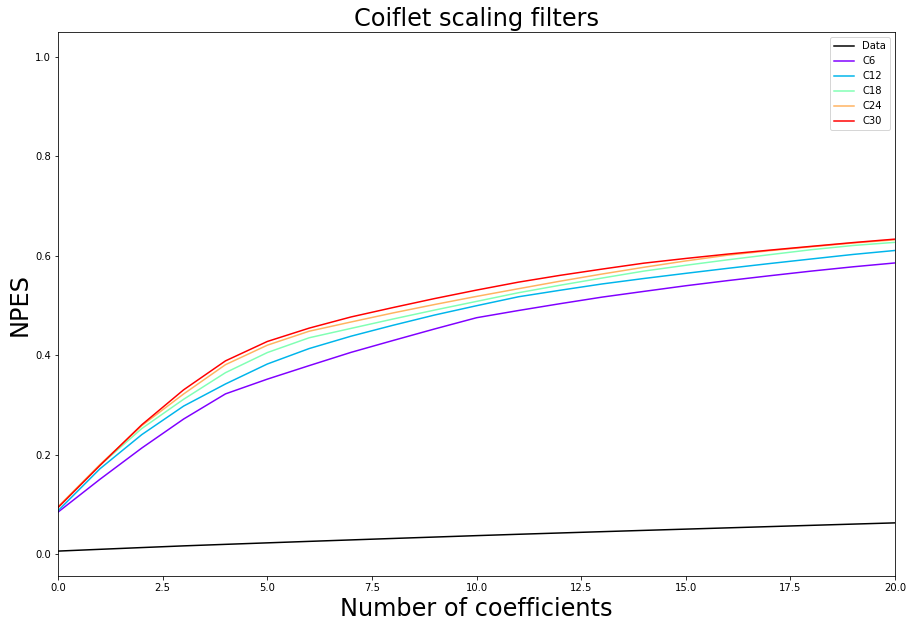

In [17]:
plot_NPES(disp, ['C6', 'C12', 'C18', 'C24', 'C30'], 9, 20, \
    'Coiflet scaling filters')

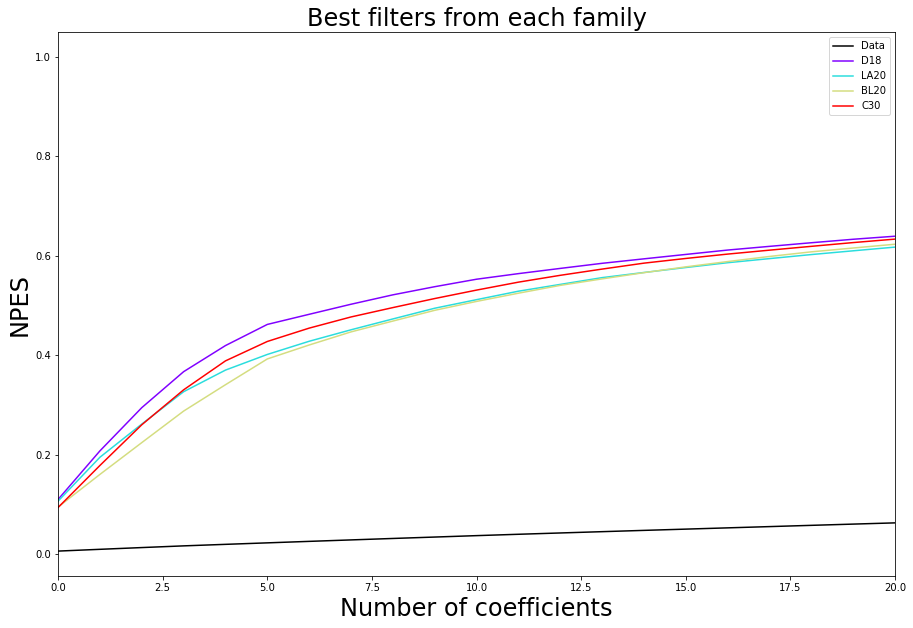

In [18]:
plot_NPES(disp, ['D18', 'LA20', 'BL20', 'C30'], 9, 20, \
    'Best filters from each family')

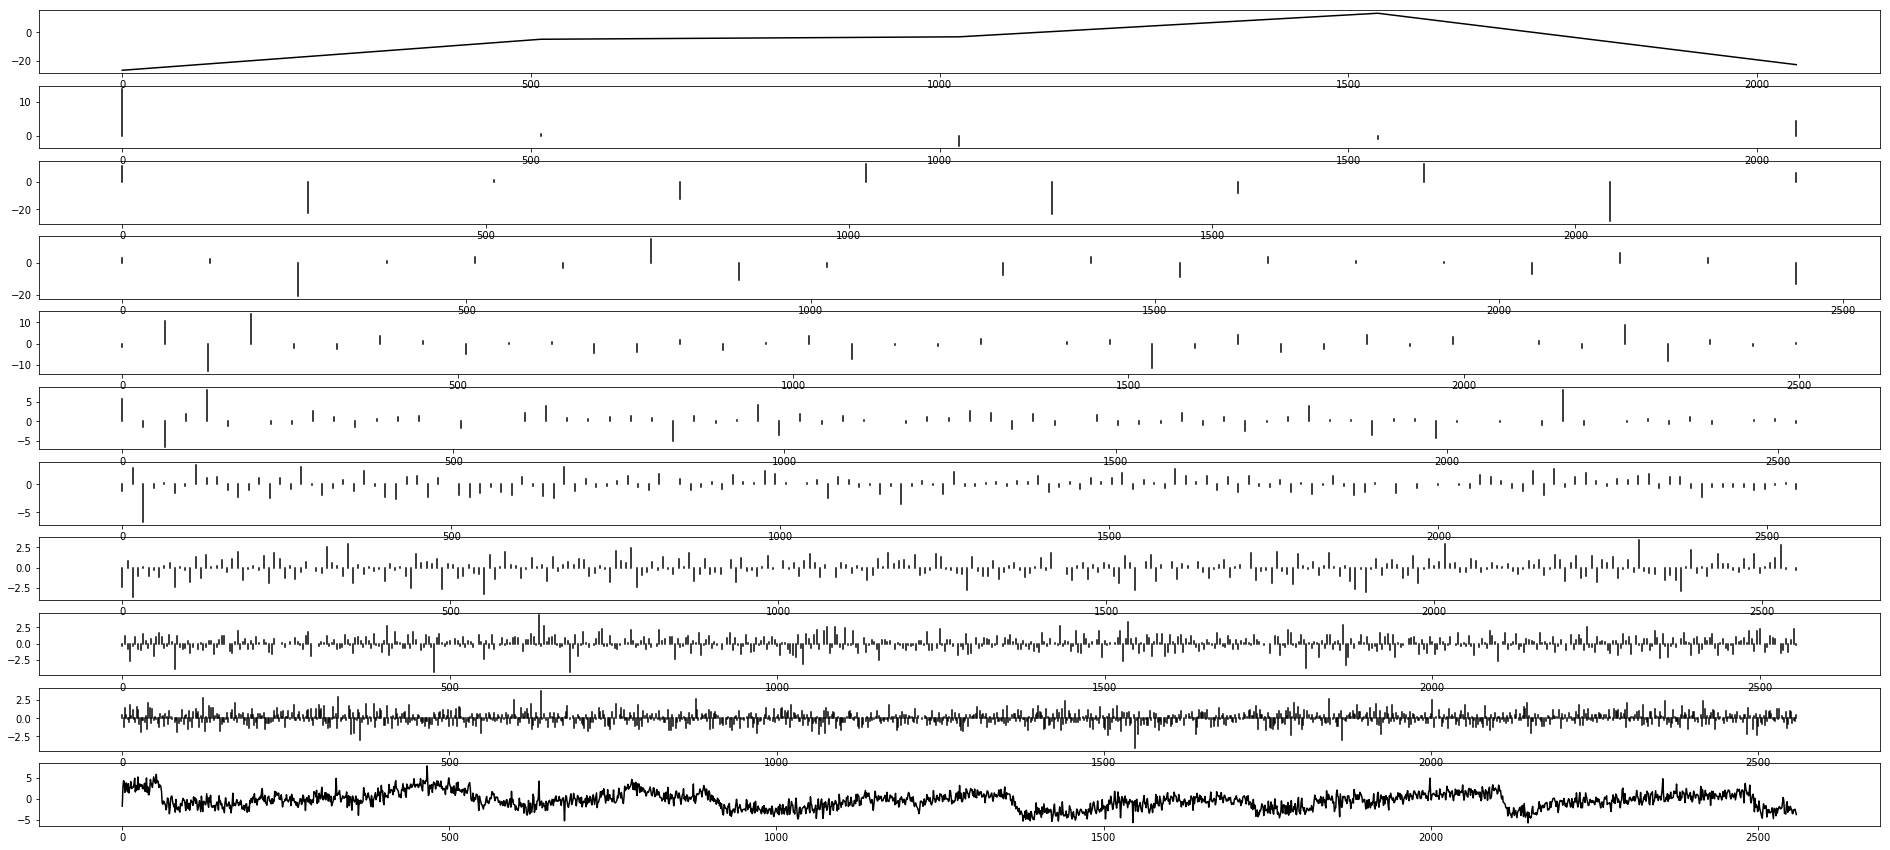

In [19]:
DWT.plot_W(disp, 'LA8', 9)